All configuration and model checks passed.
Layer depths = [   0.      9.37   16.03   37.22   48.54   68.5   214.43 5000.  ]
Number of points per layer along Z = [ 2  1  3  1  1  4 73]
Spacing in each layer in meters = [ 4.34388186  5.00984617  8.3798768  15.50738397 24.50348437 39.09861048
 65.45295359]
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders from past runs deleted!
QSEIS output folders

/home/koley/.conda/envs/pySeis1DNN/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/koley/.conda/envs/pySeis1DNN/lib/python3.11/site-packages/numpy/ma/core.py:2885: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/home/koley/.conda/envs/pySeis1DNN/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


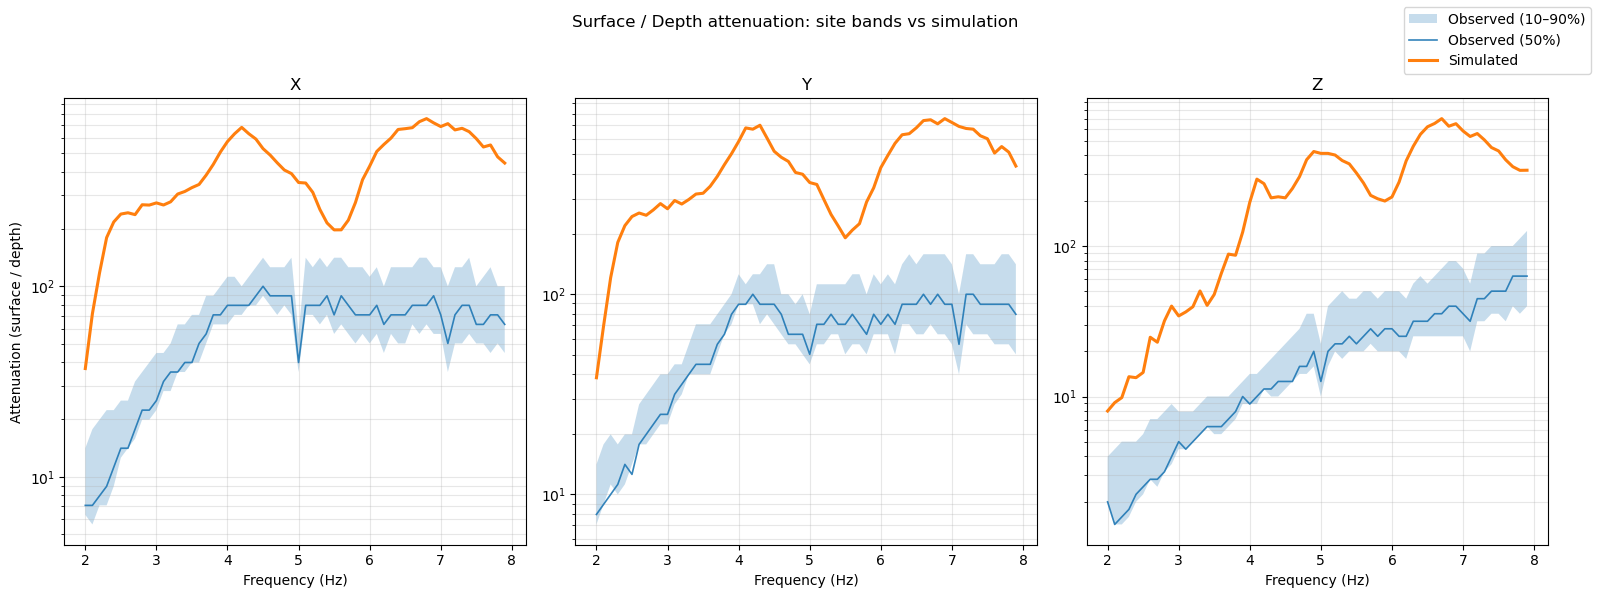

In [1]:
# script for checking the attenuation between any two points at different depths but same (x,y)
# script written to test the accuracy of simpDisp module
import numpy as np
import os
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.io import loadmat
import scipy.constants as const
from pysurf96 import surf96
from modules import configLoader
from modules import validateInputs
from  modules import createDB
from modules import simDisp
from modules import plotUtils

def main():

    # load the config file
    configFile="configParseAttnTest.ini"
    config = configLoader.load_config(configFile)
    validateInputs.validateInputs(config)
    
    splitAll = createDB.createFinalInputs(config)

    print(f"Prepared {splitAll.shape[0]} total runs")
    print(f"Cores available: {config.cpuCoresQseis}")

    results = createDB.runMultiQseis(splitAll, config.inputPath, config.qseisExe, nWorkers = config.cpuCoresQseis)
    print("Database generation complete")
    
    # flag for pure Rayleigh wavefield in homogeneous half-space
    ifRay = config.ifRay

    # flag for plane P and S waves in homogeneous half space
    ifBody = config.ifBody

    # flag for wavefield simulation
    ifFullField = config.ifFullField

    saveHV = config.saveHV

    thickness = config.thickness # units in meters
    vs = config.vS # units in m/s
    vp = config.vP # units in m/s
    rho = config.rho # units in kg/m^3
    rhoAir = config.rhoAir # density of air
    fMin = config.fMin; fMax = config.fMax; df = config.df;# units in Hz
    lambdaFrac = config.lambdaFrac # fraction
    lambdaRes = config.lambdaRes; #must be greater than 4
    
    # given a cuboidal domain should be greater than sqrt of 
    xMaxGF = config.xMaxGF # maximum horizontal offset upto which displacements will be used
    zMaxGF = config.zMaxGF # maximum depth upto which displacements will be used
    maxRec = config.maxRec # same value of number of receivers that qseis can handle in one go check qsglobal.h
    
    xMin = -config.xExtent; xMax = config.xExtent # minimum and maximum of the simulation domain in X-direction (EW)
    yMin = -config.yExtent; yMax = config.yExtent # maximum and minimum of the simulation domain in Y-direction (NS)
    zMin = 0.0; zMax = config.zExtent # maximum and minimum of the simulation domain in Z-direction (depth)

    # check if the GFs are generated up to correct hoizontal offsets
    xDiag = (xMax-xMin)*np.sqrt(2); yDiag = (yMax-yMin)*np.sqrt(2);
    if(xMaxGF<xDiag or xMaxGF<yDiag):
        raise ValueError("xMaxGF must be >= sqrt(2)x(xMax-xMin) and sqrt(2)x(yMax-yMin)")

    if(zMaxGF<zMax):
        raise ValueError("zMaxGF must be greater >= zMax")
        
    domXYBounds = (xMin,xMax,yMin,yMax)
    cubeC = config.cavityDepth; rCavity = config.cavityRadius
    cubeS = 2*rCavity
    cubeTop = cubeC-cubeS; cubeBot = cubeC+cubeS
    
    G = const.G
    
    # some other inputs for simDisp
    maxRec = config.maxRec; # same value of number of receivers that qseis can handle in one go check qsglobal.h
    tMax = config.tMax; nSamp = config.nSamp
    
    # specify the folder where you want to write all input files, should have rw access
    # fInpPath is the path where the Green's function database exists
    fInpPath = config.inputPath #like "/data/gravwav/koley/QseisInpN/"
    #fInpPath = "/data/gravwav/koley/SALVUSOut/"

    # outDispPath should have rw access and is used for saving temp displacementy files
    outDispPath = config.outDispPath # like "/data/gravwav/koley/OutDisp/"

    # saves the NN and displacement values per realization
    outDispRea = config.outDispPathRea # like "/data/gravwav/koley/OutDispRea/"
    
    # GF components to be used
    components = ['fh-2.tz', 'fh-2.tr', 'fh-2.tt', 'fz-2.tz', 'fz-2.tr']

    # splitAll is necessary so load it
    nRea = config.nRea # number of realizations

    # this file is created at the time of database generation
    splitFileName = fInpPath + 'splitAll.mat'
    splitMat = loadmat(splitFileName)
    splitAll = splitMat['splitAll']

    # source distribution parameters
    R1 = config.R1; R2 = config.R2
    nSrc = config.nSrc
    srcDistri = config.srcDistri
    scaleVH = config.scaleVH

    # number of CPUs to be used for displacement and NN simulation
    nCPUDisp = config.cpuCoresDisp
    nCPUNN = config.cpuCoresNN
    computeStrategy = config.computeStrategy

    # frequency axis to be used by simDisp
    freqOut, idxFreq, df_native = simDisp.getFreqGrid(tMax, nSamp, fMin, fMax, df)
    nFreq = len(freqOut)

    # in case only Rayleigh waves in homogeneous half space is used, Rayleigh wave phase velocity is needed
    if(ifRay):
        periods = 1/freqOut
        vR = surf96(thickness,vp,vs,rho,periods,wave="rayleigh",mode=1,velocity="phase",flat_earth=True)
    else:
        vR = None
    # two depth points for scaling, displacement saved per realization
    zTar = np.array((0.0, 250.0,))
    gridX = np.array((0.0,))
    gridY = np.array((0.0,))

    #recDistAB = np.sqrt((gridX[0]-gridX[1])**2 + (gridY[0]-gridY[1])**2 + (zTar[0]-zTar[1])**2)
    
    # nFreqx3 for the three percentiles
    attnZObs = np.zeros((nFreq,3), dtype=np.complex128)
    attnXObs = np.zeros((nFreq,3), dtype=np.complex128)
    attnYObs = np.zeros((nFreq,3), dtype=np.complex128)
    attnZSim = np.zeros((nFreq,), dtype=np.complex128)
    attnXSim = np.zeros((nFreq,), dtype=np.complex128)
    attnYSim = np.zeros((nFreq,), dtype=np.complex128)
    dispTotalAllReaSurf = np.zeros((nFreq,1,3), dtype=np.complex128)
    dispTotalAllReaDepth = np.zeros((nFreq,1,3), dtype=np.complex128)
    
    for reaNo in range(0,nRea):
        print('Doing realization = ' +str(reaNo))
        # get the source distribution per realization
        xSrc, ySrc, azSrc, srcMeta =  simDisp.genAmbSrc(nSrc , mode = srcDistri, R1 = R1, R2 = R2, xMin=xMin, xMax=xMax, yMin=yMin,
                                           yMax=yMax, randomPhase=True, freqDependent=True, nFreq=nFreq, decoupledHV=config.decoupledHV,
                                           scaleVH = scaleVH)
        
        #srcMeta["ampV"] *= 0.0
        #ySrc = np.zeros((nSrc,))

        # in case the body wave in homogeneous half-space flag is turned on
        if(ifBody):
            metaBody = simDisp.genBodySrc(nSrc, nFreq)
        else:
            metaBody=None
        
        dispTotalSurf, outDir, fOut = simDisp.computeFullDispN(zTar[0], gridX, gridY, xSrc, ySrc, azSrc, srcMeta, idxFreq, freqOut, fMin, fMax,
                     outDispPath, splitAll, xMaxGF, fInpPath, components, nCPU=1, nChunk=20000, minVel=100.0,
                     computeStrategy=computeStrategy, saveHV=saveHV)
        
        dispTotalDepth, outDir, fOut = simDisp.computeFullDispN(zTar[1], gridX, gridY, xSrc, ySrc, azSrc, srcMeta, idxFreq, freqOut, fMin, fMax,
                     outDispPath, splitAll, xMaxGF, fInpPath, components, nCPU=1, nChunk=20000, minVel=100.0,
                     computeStrategy=computeStrategy, saveHV=saveHV)
        # populate the cross correlation matrices
        
        dispTotalAllReaSurf += (np.abs(dispTotalSurf))**2
        dispTotalAllReaDepth += (np.abs(dispTotalDepth))**2

    dispTotalAllReaSurf = np.sqrt(dispTotalAllReaSurf/nRea)
    dispTotalAllReaDepth = np.sqrt(dispTotalAllReaDepth/nRea)
    
          
    attnXSim += (dispTotalAllReaSurf[:,0,0]/dispTotalAllReaDepth[:,0,0])
    attnYSim += (dispTotalAllReaSurf[:,0,1]/dispTotalAllReaDepth[:,0,1])
    attnZSim += (dispTotalAllReaSurf[:,0,2]/dispTotalAllReaDepth[:,0,2])

    attnSim = np.stack((attnXSim,attnYSim,attnZSim),axis=-1)
    print(np.shape(attnSim))    
    # load Terziet Attenuation
    terzAttn = loadmat(os.path.join(config.siteASDPath,'attnModel.mat'))
    for i in range(0,3):
        attnXObs[:,i] = np.interp(freqOut,terzAttn['attnE'][:,0],terzAttn['attnE'][:,i+1])
        attnYObs[:,i] = np.interp(freqOut,terzAttn['attnN'][:,0],terzAttn['attnN'][:,i+1])
        attnZObs[:,i] = np.interp(freqOut,terzAttn['attnZ'][:,0],terzAttn['attnZ'][:,i+1])
    
    figAttn, axAttn = plotUtils.plotAttn(freqOut, attnSim, attnXObs, attnYObs, attnZObs)

if __name__ == "__main__":
    main()

In [1]:
import os
print("OMP:", os.environ.get("OMP_NUM_THREADS"))
print("MKL:", os.environ.get("MKL_NUM_THREADS"))
print("OPENBLAS:", os.environ.get("OPENBLAS_NUM_THREADS"))
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
print("OMP:", os.environ.get("OMP_NUM_THREADS"))
print("MKL:", os.environ.get("MKL_NUM_THREADS"))
print("OPENBLAS:", os.environ.get("OPENBLAS_NUM_THREADS"))

OMP: None
MKL: None
OPENBLAS: None
OMP: 1
MKL: 1
OPENBLAS: 1


In [3]:
np.shape(attnSim)

NameError: name 'attnSim' is not defined